importing modules
loading files
reshaping array
masking array
removing pixels with only zeros
running ICA
identifying elastic and inelastic components and save outputs
Saving component figure at /home/users/eejap002/ica_scripts/component_plots/all_iran/spatial/3_components/028A_05385_191813/028A_05385_191813_component_0.png
Saving component figure at /home/users/eejap002/ica_scripts/component_plots/all_iran/spatial/3_components/028A_05385_191813/028A_05385_191813_component_1.png
Saving component figure at /home/users/eejap002/ica_scripts/component_plots/all_iran/spatial/3_components/028A_05385_191813/028A_05385_191813_component_2.png
mean_gradient [0.00011792155014146773, -0.005247204258403366, -0.0008089333665980137]
median_r_squared [0.0018432920102508209, 0.9894848248852783, 0.006162702522091443]
median_mae [4.496591070101877, 0.2586462795850979, 5.791446927127793]
mean_second_derivative [-0.00017760507079318677, 1.460757445323453e-05, -0.0004564527239532278]
Saving inelastic compon

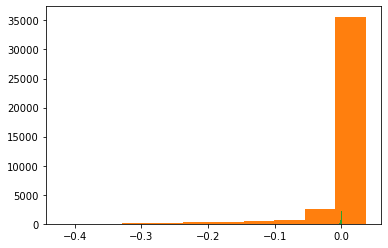

In [15]:
#!/usr/bin/env python

print("importing modules")

import os
from sklearn.decomposition import FastICA, PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from osgeo import gdal
import rasterio
from scipy.interpolate import interp2d
from numpy.ma import masked_array
import glob
import h5py
from datetime import datetime, timedelta
import geopandas as gpd
from scipy.stats import linregress
from matplotlib.dates import date2num, num2date
import pandas as pd
from shapely.geometry import Point, Polygon
from rasterio.transform import from_origin
import netCDF4 as nc
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shutil
import argparse

# this is Andrew Watson's library of functions, see https://github.com/Active-Tectonics-Leeds/interseismic_practical
import sys
import interseis_lib as lib

#---------VARIABLES TO CHANGE--------#
n_components=3
out_dir="/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran_data/outputs/archive/spatial_2016_2022/"
data_dir="/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran_data/"
plot_dir="/home/users/eejap002/ica_scripts/component_plots/all_iran/"
polygon_dir="/home/users/eejap002/ica_scripts/polygons/"
approach="spatial" # choose spatial or temporal

print('loading files')
cumh5_dir = os.path.join(data_dir,"cumh5_2016_2022")
mask_dir = os.path.join(data_dir,"mask_2016_2022")
EQA_dir = os.path.join(data_dir,"EQA.dem_par_2016_2022")
subs_poly_path = os.path.join(data_dir,"vU_merge_161023_noBabRas_WGS84_fillednosmooth_wmean_rad2_dist18_ltemin10_polygonised_dissolved.shp")

# Parse command-line arguments
# parser = argparse.ArgumentParser(description='Process a Frame.')
# parser.add_argument('--frame', type=str, help='Frame name')
# args = parser.parse_args()
# frame= args.frame

#frame='Javin_159A_05389_131313'
frame='028A_05385_191813'

#-------------------------------------------#
# Define the calc_model function
def calc_model(dph, imdates_ordinal, model):
    imdates_years = imdates_ordinal / 365.25  # Convert ordinal dates to years

    # Construct design matrix A based on the selected model
    A = sm.add_constant(imdates_years)  # Add constant term

    if model == 1:  # Annual+L
        sin = np.sin(2 * np.pi * imdates_years)
        cos = np.cos(2 * np.pi * imdates_years)
        A = np.concatenate((A, sin[:, np.newaxis], cos[:, np.newaxis]), axis=1)
    elif model == 2:  # Quad
        A = np.concatenate((A, (imdates_years ** 2)[:, np.newaxis]), axis=1)
    elif model == 3:  # Annual+Q
        sin = np.sin(2 * np.pi * imdates_years)
        cos = np.cos(2 * np.pi * imdates_years)
        A = np.concatenate((A, (imdates_years ** 2)[:, np.newaxis], sin[:, np.newaxis], cos[:, np.newaxis]),
                           axis=1)

    # Fit OLS model and predict values
    result = sm.OLS(dph, A, missing='drop').fit()
    yvalues = result.predict(A)

    return yvalues

#frame is region if running individual region
frames_data = []

EQA_par_pattern = os.path.join(EQA_dir,f"*{frame}_GEOCml*GACOS*mask_EQA.dem_par")
EQA_par_file = glob.glob(EQA_par_pattern)
cumh5_pattern = os.path.join(cumh5_dir,f"*{frame}_GEOCml*GACOS*mask_cum.h5")
cumh5_file = glob.glob(cumh5_pattern)
mask_pattern = os.path.join(mask_dir,f"*{frame}_GEOCml*GACOS*mask_coh_03_mask.geo.tif")
mask_file = glob.glob(mask_pattern)

with h5py.File(cumh5_file[0], 'r') as file:
    imdates = file['imdates']
    imdates = imdates[:] 
    vel = file['vel']
    vel = vel[:]
    cum = file['cum']
    cum = cum[:]

dates=[]
for date_value in imdates:
    date_string = str(date_value)  # Convert int32 to string
    year = int(date_string[:4])
    month = int(date_string[4:6])
    day = int(date_string[6:])
    real_date = datetime(year, month, day)
    dates.append(real_date)    

width = int(lib.get_par(EQA_par_file[0],'width'))
length = int(lib.get_par(EQA_par_file[0],'nlines'))
    
# get corner positions
corner_lat = float(lib.get_par(EQA_par_file[0], 'corner_lat'))
corner_lon = float(lib.get_par(EQA_par_file[0], 'corner_lon'))

# get post spacing (distance between velocity measurements)
post_lat = float(lib.get_par(EQA_par_file[0],'post_lat'))
post_lon = float(lib.get_par(EQA_par_file[0],'post_lon'))

# calculate grid spacings
lat = corner_lat + post_lat*np.arange(1,length+1) - post_lat/2
lon = corner_lon + post_lon*np.arange(1,width+1) - post_lon/2

frames_data.append({
    'frame': frame,
    'EQA_file': EQA_par_file,
    'cumh5_file': cumh5_file,
    'mask_file': mask_file,
    'imdates': imdates,
    'vel': vel,
    'cum': cum,
    'dates': dates,
    'width': width,
    'length': length,
    'corner_lat': corner_lat,
    'corner_lon': corner_lon,
    'post_lat': post_lat,
    'post_lon': post_lon,
    'lat': lat,
    'lon': lon
        })

# Create GeoDataFrame
frames_gdf = gpd.GeoDataFrame(frames_data, columns=['frame', 'EQA_file', 'cumh5_file', 'mask_file', 'imdates', 'vel', 'cum', 'dates', 'width', 'length', 'corner_lat', 'corner_lon', 'post_lat', 'post_lon','lat', 'lon'])

print("reshaping array")
# cum shape is (t, lat, lon)
# we want to make an array of (time, pixels)
# we want to reshape cum (202, 268, 327) into (202,(268*327))

frames_gdf["cum_"] = ""

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    cum_data = row['cum']

    # Check if 'cum' data is not empty
    if not np.isnan(cum_data).all():
        cum_shape = cum_data.shape
        n_pix = cum_shape[1] * cum_shape[2]

        cum_ = np.reshape(cum_data, (cum_shape[0], n_pix))
        frames_gdf.at[index, 'cum_'] = cum_

# we have cum of shape 202, 268, 327 and mask tif. We want to mask cum with mask tif 
# i.e. make pixels in cum nan where mask_tif = 0. NaNs are where no data e.g. outside of frame, low coh...

print("masking array")
frames_gdf["cum_masked_2d"] = ""
frames_gdf["cum_masked_3d"] = ""

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    cum_data = row['cum_']
    cum_data_3d = row['cum']
    mask = row['mask_file']

    with rasterio.open(mask[0]) as tif:
    # Read the raster data
        mask_tif = tif.read(1)

        # Reshape the mask to 1D
        mask_1d = mask_tif.flatten()

        # Tile the first row along the rows to match the shape of asc_cum_
        mask_2d = np.tile(mask_1d, (cum_data.shape[0],1))
        
        # Apply the mask to every element in the 3D array
        cum_masked = cum_data * mask_2d
        cum_masked_3d = cum_masked.reshape(cum_data_3d.shape)
        
        frames_gdf.at[index, 'cum_masked_2d'] = cum_masked
        frames_gdf.at[index, 'cum_masked_3d'] = cum_masked_3d

# Find columns (pixels) containing only zeros in the t-s and mask them
print("removing pixels with only zeros")
frames_gdf["cum_no_nans_zeros"] = ""
frames_gdf["non_zero_ind"] = ""
frames_gdf["non_nan_ind"] = ""

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    cum_masked = row['cum_masked_2d']

    zero_pixels = np.all(cum_masked == 0, axis=0)
    
    # Create a new data array without columns (pixels) containing all zeros
    cum_no_zeros = cum_masked[:, ~zero_pixels]
    
    # Print how many NaNs there are
    nan_indices = np.argwhere(np.isnan(cum_no_zeros))

    # find columns containing NaNs and zeroes
    nan_pixels = np.any(np.isnan(cum_no_zeros), axis=0)

    # create a new data array without nan columns (pixels)
    cum_no_zeros_no_nans = cum_no_zeros[:, ~nan_pixels]

    zero_ind = np.argwhere(zero_pixels).flatten()
    non_zero_ind = np.argwhere(~zero_pixels).flatten()

    nans = np.any(np.isnan(cum_masked), axis=0)
    nan_ind = np.argwhere(nans).flatten()
    non_nan_ind = np.argwhere(~nans).flatten()

    frames_gdf.at[index, 'cum_no_nans_zeros'] = cum_no_zeros_no_nans
    frames_gdf.at[index, 'non_zero_ind'] = non_zero_ind
    frames_gdf.at[index, 'non_nan_ind'] = non_nan_ind

# Apply spatial or temporal ICA
frames_gdf["S_ft"] = ""
frames_gdf["restored_signals_2d"] = ""
frames_gdf["restored_signals_3d"] = ""

# attempt ICA
ncomponents=n_components

print("running ICA")
for index, row in frames_gdf.iterrows():
    frame = row['frame']
    data = row['cum_no_nans_zeros']
    non_nan_ind = row['non_nan_ind']
    non_zero_ind = row['non_zero_ind']
    cum = row['cum']
    
    if approach == "temporal":
        data_to_decompose = data.T  # Shape: pixels, time
        if data_to_decompose.shape[0] > ncomponents and data.shape[1] > ncomponents:
            # Perform ICA
            # set up the transformer (ica). In MATLAB you do the whitening first then the transforming, here you do it in one.
            ica = FastICA(n_components=ncomponents, whiten="unit-variance")
        	
            # fit the transformer to the data array
            S_ft = ica.fit_transform(data_to_decompose) # fit model and recover signals
            #S_t = ica.transform(data) # recover sources from x using unmixing matrix
            ## S_ft and S_t results should be identical as ica.transform uses mixing matrix calculated by ica.fit_trcd ansform
        
            frames_gdf.at[index, 'S_ft'] = S_ft
        
            # Take each signal and restore with outer product
            restored_signals_outer = []
            reconstructed_data_test = []
            three_d_list = []
            for j in range(ncomponents):
                S_j = np.copy(S_ft)
                signal = S_j[:,j]
                mixing = ica.mixing_[:,j]
                restored_signal_j = np.outer(signal, mixing)
                #reconstructed_data = ica.inverse_transform(S_ft) # test tp check method
                
                # Append the restored signal to the list
                restored_signals_outer.append(restored_signal_j)
                # reconstructed_data_test.append(reconstructed_data) test plot to check the same
        
                # Convert common_indices to 3D indices i.e. flat indices into a tuple for 3d array
                # first find indices common to non nan and non zero for data population
                common_indices = np.intersect1d(non_nan_ind, non_zero_ind)
        
                # create a shape the same size as original data with nans
                cum_with_nans = np.full((cum.shape[0], cum.shape[1], cum.shape[2]), np.nan)
        
                # Convert common_indices to 3D indices i.e. flat indices into a tuple for 3d array
                indices_3d = np.unravel_index(common_indices, cum.shape[1:])
        
                # Create a copy of cum_with_nans to work with for each restored_signal
                cum_with_nans_copy = cum_with_nans.copy()

                # need to make sure a different time series assigned to timestep ***
                for m in range(restored_signal_j.shape[1]):
                   # Assign values from the restored signal to non-NaN positions
                    cum_with_nans_copy[m, indices_3d[0], indices_3d[1]] = restored_signal_j[:,m]
                   
                # for m in range(restored_signal_j.shape[1]):
                #     # Assign values from the restored signal to non-NaN positions
                #     cum_with_nans_copy[m, indices_3d[0], indices_3d[1]] = restored_signal_j[:,m]
        
                # reshape cum_with_nans into time x pixels
                cum_with_nans_pix = cum_with_nans_copy.reshape(cum.shape[0], cum.shape[1] * cum.shape[2])
        
                #reshape cum_with_nans_pix into 3d to save signals
                restored_signal_3d = cum_with_nans_pix.reshape(cum.shape[0], cum.shape[1], cum.shape[2])
                three_d_list.append(restored_signal_3d)
                
            frames_gdf.at[index, 'restored_signals_2d'] = restored_signals_outer   
            frames_gdf.at[index, 'restored_signals_3d'] = three_d_list
        else:
            print("Skipping ICA for frame {} because the number of features is not greater than {}.".format(frame, ncomponents))
    
    elif approach == "spatial":
        data_to_decompose = data # Shape: time, pixels

        if data.shape[1] > ncomponents and data.shape[0] > ncomponents:
        # Perform ICA
            # set up the transformer (ica). In MATLAB you do the whitening first then the transforming, here you do it in one.
            ica = FastICA(n_components=ncomponents, whiten="unit-variance")
        	
            # fit the transformer to the data array
            S_ft = ica.fit_transform(data_to_decompose) # fit model and recover signals
            #S_t = ica.transform(data) # recover sources from x using unmixing matrix
            ## S_ft and S_t results should be identical as ica.transform uses mixing matrix calculated by ica.fit_trcd ansform
        
            frames_gdf.at[index, 'S_ft'] = S_ft
        
            # Take each signal and restore with outer product
            restored_signals_outer = []
            three_d_list = []
            for j in range(ncomponents):
                S_j = np.copy(S_ft)
                signal = S_j[:,j]
                mixing = ica.mixing_[:,j]
                restored_signal_j = np.outer(signal, mixing)
                
                # Append the restored signal to the list
                restored_signals_outer.append(restored_signal_j)
        
                # Convert common_indices to 3D indices i.e. flat indices into a tuple for 3d array
                # first find indices common to non nan and non zero for data population
                common_indices = np.intersect1d(non_nan_ind, non_zero_ind)
        
                # create a shape the same size as original data with nans
                cum_with_nans = np.full((cum.shape[0], cum.shape[1], cum.shape[2]), np.nan)
        
                # Convert common_indices to 3D indices i.e. flat indices into a tuple for 3d array
                indices_3d = np.unravel_index(common_indices, cum.shape[1:])
        
                # Create a copy of cum_with_nans to work with for each restored_signal
                cum_with_nans_copy = cum_with_nans.copy()
                
                # need to make sure a different time series assigned to timestep
                for m in range(restored_signal_j.shape[0]):
                    # Assign values from the restored signal to non-NaN positions
                    cum_with_nans_copy[m, indices_3d[0], indices_3d[1]] = restored_signal_j[m,:]
        
                # reshape cum_with_nans into time x pixels
                cum_with_nans_pix = cum_with_nans_copy.reshape(cum.shape[0], cum.shape[1] * cum.shape[2])
        
                #reshape cum_with_nans_pix into 3d to save signals
                restored_signal_3d = cum_with_nans_pix.reshape(cum.shape[0], cum.shape[1], cum.shape[2])
                three_d_list.append(restored_signal_3d)
                
            frames_gdf.at[index, 'restored_signals_2d'] = restored_signals_outer   
            frames_gdf.at[index, 'restored_signals_3d'] = three_d_list
        else:
            print("Skipping ICA for frame {} because the number of features is not greater than {}.".format(frame, ncomponents))

if approach == "temporal":
    # find inelastic component, elastic component, plot things, save nc and tif
    print("identifying elastic and inelastic components and save outputs")
    for index, row in frames_gdf.iterrows():
        frame = row['frame']
        dates = row['dates']
        restored_signals_3d = row['restored_signals_3d']
        restored_signals_2d = row['restored_signals_2d']
        corner_lat = row['corner_lat']
        corner_lon = row['corner_lon']
        post_lon = row['post_lon']
        post_lat = row['post_lat']
        width = row['width']
        height = row['length']
        lat = row['lat']
        lon = row['lon']
        nc_data = row['imdates']
        Sft = row['S_ft']
    
        # Only proceed if there are enough coherent pixels
        if restored_signals_3d[0].shape[1] >= 20:
            # List to store R-squared values for each trend
            mean_gradient = []
            median_r_squared = []
            mean_second_derivative = []
            median_mae = []
    
            # Convert dates to numerical values
            num_dates = date2num(dates)
    
            for m, signal_0 in enumerate(restored_signals_2d):
                r_squared_values = []
                gradient = []
                second_deriv = []
                maes = []

                # transpose signal for linear regression etc.
                signal = signal_0.T
    
                # Loop through each trend at each pixel
                for i in range(signal.shape[1]):
                    # Perform linear regression and calculate R-squared
                    slope, _, r_value, _, _ = linregress(num_dates, signal[:, i]) 
    
                    # Store the gradient at each pixel
                    gradient.append(slope)
    
                    # Append R-squared value to the list
                    r_squared_values.append(r_value ** 2)
    
                    # Calculate the second derivative using numpy.gradient at each pixel
                    first_derivative = np.gradient(signal[:, i], num_dates)
                    second_derivative = np.gradient(first_derivative, num_dates)
                    second_derivative_mean = np.mean(second_derivative)
                    second_deriv.append(second_derivative_mean)
    
                    # choose model 1 (annual + L) and then calculate fit useing MAE
                    yvalues = calc_model(signal[:, i], num_dates, 3)
                    mae_annual = mean_absolute_error(signal[:, i], yvalues)
                    maes.append(mae_annual)
                        
                # take mean of gradients
                mean_gradient.append(np.mean(gradient))
    
                # take median of r_squared per IC
                median_r_squared.append(np.median(r_squared_values))
    
                # find median mae of fit of model and signal
                median_mae.append(np.median(maes))
    
                # take mean of second derivative per IC
                mean_second_derivative.append(np.mean(second_deriv))
    
                # plot components in space and time with parameters
                fig = f"{frame}_component_{m}.png"
                fig_directory = os.path.join(plot_dir, approach, f"{n_components}_components", frame)
    
                # Check if the directory exists, if not, create it
                if not os.path.exists(fig_directory):
                        os.makedirs(fig_directory)
                
                # plot components in space and time with parameters
                plt.figure(figsize=(16,5))
                plt.subplot2grid((1, 3), (0, 0))
                plt.plot(dates,signal)
    
                # Adding text to the top right of the plot
                plt.text(0.95, 0.95, f"Gradient: {np.mean(gradient):.4f}\nR Squared: {np.median(r_squared_values):.4f}\nMAE: {np.median(maes):.4f}\nSecond Derivative: {np.mean(second_deriv):.4f}",
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform=plt.gca().transAxes,
                     bbox=dict(facecolor='white', alpha=0.5))
                
                plt.subplot2grid((1, 3), (0, 1))
                plt.imshow(restored_signals_3d[m][-1,:,:], cmap='viridis', interpolation='none', extent=[np.amin(lon), np.amax(lon), np.amin(lat), np.amax(lat)])
                cbar = plt.colorbar(label='mm/yr', shrink=0.6)
                plt.text(0.95, 0.95, "Reconstructed time series",
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform=plt.gca().transAxes,
                     bbox=dict(facecolor='white', alpha=0.5))
                
                plt.subplot2grid((1, 3), (0, 2))
                plt.plot(dates,ica.mixing_[:,m], label = 'Component time series {}'.format(m))
                plt.legend()
                print('Saving component figure at {}/{}'.format(fig_directory, fig))
                plt.savefig(os.path.join(fig_directory, fig))
                plt.close()
    
    #-----------------------------#
            # If mean gradient is negative, find the index of the trend with the maximum R-squared value
            negative_indices = [i for i, val in enumerate(mean_gradient) if val < 0]
            if negative_indices:
                median_r_squared_negative_gradients = [median_r_squared[i] for i in negative_indices]
                max_r_squared_negative_grad = np.max(median_r_squared_negative_gradients)
                max_index_in_median_r_squared = median_r_squared.index(max_r_squared_negative_grad)
                
        	    # Choose the signal
                inelastic_signal = restored_signals_3d[max_index_in_median_r_squared]
                inelastic_signal_subsiding = restored_signals_2d[max_index_in_median_r_squared]
                inelastic_S_ft = ica.mixing_[:,max_index_in_median_r_squared]
                
                print('mean_gradient',mean_gradient)
                print('median_r_squared',median_r_squared)
                print('median_mae',median_mae)
                print('mean_second_derivative',mean_second_derivative)
                
        	    # Save as NetCDF
                output_dir = os.path.join(out_dir, approach, f"{ncomponents}_comp", frame)
    
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
    
                # Remove all files in the directory
                for filename in os.listdir(output_dir):
                    file_path = os.path.join(output_dir, filename)
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)  # Remove the file or link
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)  # Remove the directory and its contents
                            
                # cp inelastic png to outputs
                #shutil.copy(os.path.join(fig_directory, f"{frame}_component_{max_index_in_median_r_squared}.png"),output_dir)
    
                print('Saving inelastic component nc and tif at {}'.format(output_dir))
    
                output_nc_path = os.path.join(output_dir, f"{frame}_{ncomponents}_components.nc")
                with nc.Dataset(output_nc_path, 'w') as file:
                    # Create dimensions
                    file.createDimension('dates', inelastic_signal.shape[0])
                    file.createDimension('latitude', inelastic_signal.shape[1])
                    file.createDimension('longitude', inelastic_signal.shape[2])
                    
                    # Create variables
                    time_var = file.createVariable('dates', np.int32, ('dates',))
                    lat_var = file.createVariable('latitude', 'f4', ('latitude',))
                    lon_var = file.createVariable('longitude', 'f4', ('longitude',))
                    data_var = file.createVariable('inelastic_reconstructed_signals', 'f4', ('dates', 'latitude', 'longitude'))
                    component_var = file.createVariable('inelastic_component', 'f4', ('dates'))
                    mae_var = file.createVariable('inelastic_MAE', 'f4')
                    second_derivative_var = file.createVariable('inelastic_second_derivative', 'f4')
                    
                    # Add data to variables
                    time_var[:] = nc_data
                    lat_var[:] = lat
                    lon_var[:] = lon
                    data_var[:] = inelastic_signal
                    component_var[:] = inelastic_S_ft
                    mae_var[:] = median_mae[max_index_in_median_r_squared]
                    second_derivative_var[:] = mean_second_derivative[max_index_in_median_r_squared]
    
                    # Create variables for each component
                    data_vars = []
                    component_vars = []
                    mae_vars = []
                    second_derivative_vars = []
                    
                    for comp_index in range(ncomponents - 1):
                        data_var = file.createVariable(f'reconstructed_signals_{comp_index}', 'f4', ('dates', 'latitude', 'longitude'))
                        component_var = file.createVariable(f'component_{comp_index}', 'f4', ('dates'))
                        mae_var = file.createVariable(f'mae_{comp_index}', 'f4')
                        second_derivative_var = file.createVariable(f'second_derivative_{comp_index}', 'f4')
                        
                        data_vars.append(data_var)
                        component_vars.append(component_var)
                        mae_vars.append(mae_var)
                        second_derivative_vars.append(second_derivative_var)
    
                    # Add data, mae, and second derivative to variables
                    comp_index=0
                    for i, signal_3d in enumerate(restored_signals_3d):
                        if i != max_index_in_median_r_squared:
                            data_vars[comp_index][:] = signal_3d
                            component_vars[comp_index][:] = ica.mixing_[:,i] 
                            mae_vars[comp_index][:] = median_mae[i]
                            second_derivative_vars[comp_index][:] = mean_second_derivative[i]
                            comp_index += 1
    
                # cp elastic png to outputs
                for i in range(len(restored_signals_3d)):
                    shutil.copy(os.path.join(fig_directory, f"{frame}_component_{i}.png"), output_dir)
    
                print("Saving other component tifs at {}".format(output_dir))
    
                # Save as GeoTIFF
                output_tif_path = os.path.join(output_dir, f"{frame}_inelastic_component_{max_index_in_median_r_squared}.tif")
    
                # Create a transformation for the GeoTIFF
                post_lat_pos = post_lat * (-1)
                transform = from_origin(corner_lon, corner_lat, post_lon, post_lat_pos)
    
                with rasterio.open(output_tif_path, 'w', driver='GTiff', height=height, width=width, count=1,
                                   dtype='float32', crs='EPSG:4326', transform=transform) as dst:
                    # Write the data to the GeoTIFF
                    dst.write(inelastic_signal[-1, :, :], 1)
                               
                for i, signal_3d in enumerate(restored_signals_3d):
                    if i != max_index_in_median_r_squared:
                        output_tif_path = os.path.join(output_dir, f"{frame}_component_{i}.tif")
                        with rasterio.open(output_tif_path, 'w', driver='GTiff', height=height, width=width, count=1,
                                           dtype='float32', crs='EPSG:4326', transform=transform) as dst:
                            # Write the data to the GeoTIFF
                            dst.write(signal_3d[-1, :, :], 1)

elif approach == "spatial":
    # find inelastic component, elastic component, plot things, save nc and tif
    print("identifying elastic and inelastic components and save outputs")
    for index, row in frames_gdf.iterrows():
        frame = row['frame']
        dates = row['dates']
        restored_signals_3d = row['restored_signals_3d']
        restored_signals_2d = row['restored_signals_2d']
        corner_lat = row['corner_lat']
        corner_lon = row['corner_lon']
        post_lon = row['post_lon']
        post_lat = row['post_lat']
        width = row['width']
        height = row['length']
        lat = row['lat']
        lon = row['lon']
        nc_data = row['imdates']
        Sft = row['S_ft']
    
        # Only proceed if there are enough coherent pixels
        if restored_signals_2d[0].shape[1] >= 20:
            # List to store R-squared values for each trend
            mean_gradient = []
            median_r_squared = []
            mean_second_derivative = []
            median_mae = []
    
            # Convert dates to numerical values
            num_dates = date2num(dates)
    
            for m, signal in enumerate(restored_signals_2d):
                r_squared_values = []
                gradient = []
                second_deriv = []
                maes = []
    
                # Loop through each trend at each pixel
                for i in range(signal.shape[1]):
                    # Perform linear regression and calculate R-squared
                    slope, _, r_value, _, _ = linregress(num_dates, signal[:, i])
                    # Store the gradient at each pixel
                    gradient.append(slope)
    
                    # Append R-squared value to the list
                    r_squared_values.append(r_value ** 2)
    
                    # Calculate the second derivative using numpy.gradient at each pixel
                    first_derivative = np.gradient(signal[:, i], num_dates)
                    second_derivative = np.gradient(first_derivative, num_dates)
                    second_derivative_mean = np.mean(second_derivative)
                    second_deriv.append(second_derivative_mean)
    
                    # choose model 1 (annual + L) and then calculate fit useing MAE
                    yvalues = calc_model(signal[:, i], num_dates, 3)
                    mae_annual = mean_absolute_error(signal[:, i], yvalues)
                    maes.append(mae_annual)
                        
                # take mean of gradients
                mean_gradient.append(np.mean(gradient))
                plt.hist(gradient)
    
                # take median of r_squared per IC
                median_r_squared.append(np.median(r_squared_values))
    
                # find median mae of fit of model and signal
                median_mae.append(np.median(maes))
    
                # take mean of second derivative per IC
                mean_second_derivative.append(np.mean(second_deriv))
    
                # plot components in space and time with parameters
                fig = f"{frame}_component_{m}.png"
                fig_directory = os.path.join(plot_dir, approach, f"{n_components}_components", frame)
    
                # Check if the directory exists, if not, create it
                if not os.path.exists(fig_directory):
                        os.makedirs(fig_directory)
                
                # plot components in space and time with parameters
                plt.figure(figsize=(16,5))
                plt.subplot2grid((1, 3), (0, 0))
                plt.plot(dates,signal)
    
                # Adding text to the top right of the plot
                plt.text(0.95, 0.95, f"Gradient: {np.mean(gradient):.4f}\nR Squared: {np.median(r_squared_values):.4f}\nMAE: {np.median(maes):.4f}\nSecond Derivative: {np.mean(second_deriv):.4f}",
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform=plt.gca().transAxes,
                     bbox=dict(facecolor='white', alpha=0.5))
                
                plt.subplot2grid((1, 3), (0, 1))
                plt.imshow(restored_signals_3d[m][-1,:,:], cmap='viridis', interpolation='none', extent=[np.amin(lon), np.amax(lon), np.amin(lat), np.amax(lat)])
                cbar = plt.colorbar(label='mm/yr', shrink=0.6)
                plt.text(0.95, 0.95, "Reconstructed time series",
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform=plt.gca().transAxes,
                     bbox=dict(facecolor='white', alpha=0.5))
                
                plt.subplot2grid((1, 3), (0, 2))
                plt.plot(dates,S_ft[:,m], label = 'Component time series {}'.format(m))
                plt.legend()
                print('Saving component figure at {}/{}'.format(fig_directory, fig))
                plt.savefig(os.path.join(fig_directory, fig))
                plt.close()
    
    #-----------------------------#
            # If mean gradient is negative, find the index of the trend with the maximum R-squared value
            negative_indices = [i for i, val in enumerate(mean_gradient) if val < 0]
            if negative_indices:
                median_r_squared_negative_gradients = [median_r_squared[i] for i in negative_indices]
                max_r_squared_negative_grad = np.max(median_r_squared_negative_gradients)
                max_index_in_median_r_squared = median_r_squared.index(max_r_squared_negative_grad)
                
        	    # Choose the signal
                inelastic_signal = restored_signals_3d[max_index_in_median_r_squared]
                inelastic_signal_subsiding = restored_signals_2d[max_index_in_median_r_squared]
                inelastic_S_ft = S_ft[:,max_index_in_median_r_squared]
                
                print('mean_gradient',mean_gradient)
                print('median_r_squared',median_r_squared)
                print('median_mae',median_mae)
                print('mean_second_derivative',mean_second_derivative)
                
        	    # Save as NetCDF
                output_dir = os.path.join(out_dir, approach, f"{ncomponents}_comp", frame)
    
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
    
                # Remove all files in the directory
                for filename in os.listdir(output_dir):
                    file_path = os.path.join(output_dir, filename)
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)  # Remove the file or link
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)  # Remove the directory and its contents
                            
                # cp inelastic png to outputs
                #shutil.copy(os.path.join(fig_directory, f"{frame}_component_{max_index_in_median_r_squared}.png"),output_dir)
    
                print('Saving inelastic component nc and tif at {}'.format(output_dir))
    
                output_nc_path = os.path.join(output_dir, f"{frame}_{ncomponents}_components.nc")
                with nc.Dataset(output_nc_path, 'w') as file:
                    # Create dimensions
                    file.createDimension('dates', inelastic_signal.shape[0])
                    file.createDimension('latitude', inelastic_signal.shape[1])
                    file.createDimension('longitude', inelastic_signal.shape[2])
                    
                    # Create variables
                    time_var = file.createVariable('dates', np.int32, ('dates',))
                    lat_var = file.createVariable('latitude', 'f4', ('latitude',))
                    lon_var = file.createVariable('longitude', 'f4', ('longitude',))
                    data_var = file.createVariable('inelastic_reconstructed_signals', 'f4', ('dates', 'latitude', 'longitude'))
                    component_var = file.createVariable('inelastic_component', 'f4', ('dates'))
                    mae_var = file.createVariable('inelastic_MAE', 'f4')
                    second_derivative_var = file.createVariable('inelastic_second_derivative', 'f4')
                    
                    # Add data to variables
                    time_var[:] = nc_data
                    lat_var[:] = lat
                    lon_var[:] = lon
                    data_var[:] = inelastic_signal
                    component_var[:] = inelastic_S_ft
                    mae_var[:] = median_mae[max_index_in_median_r_squared]
                    second_derivative_var[:] = mean_second_derivative[max_index_in_median_r_squared]
    
                    # Create variables for each component
                    data_vars = []
                    component_vars = []
                    mae_vars = []
                    second_derivative_vars = []
                    
                    for comp_index in range(ncomponents - 1):
                        data_var = file.createVariable(f'reconstructed_signals_{comp_index}', 'f4', ('dates', 'latitude', 'longitude'))
                        component_var = file.createVariable(f'component_{comp_index}', 'f4', ('dates'))
                        mae_var = file.createVariable(f'mae_{comp_index}', 'f4')
                        second_derivative_var = file.createVariable(f'second_derivative_{comp_index}', 'f4')
                        
                        data_vars.append(data_var)
                        component_vars.append(component_var)
                        mae_vars.append(mae_var)
                        second_derivative_vars.append(second_derivative_var)
    
                    # Add data, mae, and second derivative to variables
                    comp_index=0
                    for i, signal_3d in enumerate(restored_signals_3d):
                        if i != max_index_in_median_r_squared:
                            data_vars[comp_index][:] = signal_3d
                            component_vars[comp_index][:] = S_ft[:,i] 
                            mae_vars[comp_index][:] = median_mae[i]
                            second_derivative_vars[comp_index][:] = mean_second_derivative[i]
                            comp_index += 1
    
                # cp elastic png to outputss
                for i in range(len(restored_signals_3d)):
                    shutil.copy(os.path.join(fig_directory, f"{frame}_component_{i}.png"), output_dir)
    
                print("Saving other component tifs at {}".format(output_dir))
    
                # Save as GeoTIFF
                output_tif_path = os.path.join(output_dir, f"{frame}_inelastic_component_{max_index_in_median_r_squared}.tif")
    
                # Create a transformation for the GeoTIFF
                post_lat_pos = post_lat * (-1)
                transform = from_origin(corner_lon, corner_lat, post_lon, post_lat_pos)
    
                with rasterio.open(output_tif_path, 'w', driver='GTiff', height=height, width=width, count=1,
                                   dtype='float32', crs='EPSG:4326', transform=transform) as dst:
                    # Write the data to the GeoTIFF
                    dst.write(inelastic_signal[-1, :, :], 1)
                               
                for i, signal_3d in enumerate(restored_signals_3d):
                    if i != max_index_in_median_r_squared:
                        output_tif_path = os.path.join(output_dir, f"{frame}_component_{i}.tif")
                        with rasterio.open(output_tif_path, 'w', driver='GTiff', height=height, width=width, count=1,
                                           dtype='float32', crs='EPSG:4326', transform=transform) as dst:
                            # Write the data to the GeoTIFF
                            dst.write(signal_3d[-1, :, :], 1)